
Pareto Frontier Solutions:
                ID  Num_Vehicles         Fuel  carbon_emissions    total_cost
34     BEV_S4_2023           1.0  Electricity          0.000000  26256.007297
50     LNG_S4_2023           1.0       BioLNG        113.703206  11934.078991
48  Diesel_S4_2023           1.0          HVO        193.911994   9797.811293
47  Diesel_S4_2023           1.0          B20       1212.319794   9561.807833


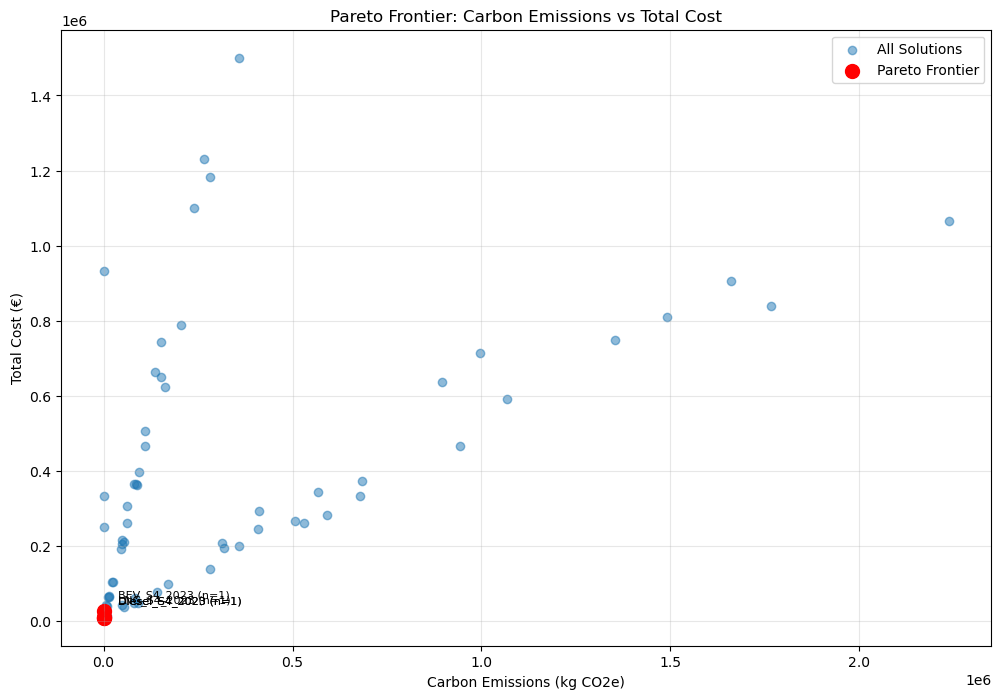


Optimization Summary (sorted by carbon emissions):
                ID  Num_Vehicles         Fuel  carbon_emissions  \
34     BEV_S4_2023           1.0  Electricity          0.000000   
50     LNG_S4_2023           1.0       BioLNG        113.703206   
48  Diesel_S4_2023           1.0          HVO        193.911994   
47  Diesel_S4_2023           1.0          B20       1212.319794   

    carbon_per_vehicle    total_cost  cost_per_vehicle  \
34            0.000000  26256.007297      26256.007297   
50          113.703206  11934.078991      11934.078991   
48          193.911994   9797.811293       9797.811293   
47         1212.319794   9561.807833       9561.807833   

    carbon_reduction_vs_max  cost_reduction_vs_max  
34               100.000000               0.000000  
50                90.621022              54.547244  
48                84.004881              62.683544  
47                 0.000000              63.582400  


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

class ParetoOptimizer:
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        self.data['total_cost'] = (
            data['fuel_costs'] + 
            data['insurance_cost'] + 
            data['maintenance_cost']
        )
        
    def is_pareto_efficient(self, costs: np.ndarray) -> np.ndarray:
        """
        Find the pareto-efficient points
        :param costs: An (n_points, n_costs) array
        :return: A boolean array of pareto-efficient points
        """
        is_efficient = np.ones(costs.shape[0], dtype = bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                # Keep any point with a lower cost in at least one dimension
                is_efficient[is_efficient] = np.any(
                    costs[is_efficient] < c, axis=1
                ) | np.all(costs[is_efficient] == c, axis=1)
        return is_efficient
    
    def find_pareto_frontier(self) -> pd.DataFrame:
        """
        Find the Pareto frontier considering carbon emissions and total cost
        """
        costs = np.column_stack([
            self.data['carbon_emissions'],
            self.data['total_cost']
        ])
        
        pareto_mask = self.is_pareto_efficient(costs)
        return self.data[pareto_mask].sort_values('carbon_emissions')
    
    def plot_pareto_frontier(self, save_path: str = None):
        """
        Plot all solutions and highlight the Pareto frontier
        """
        plt.figure(figsize=(12, 8))
        
        # Plot all points
        plt.scatter(
            self.data['carbon_emissions'],
            self.data['total_cost'],
            alpha=0.5,
            label='All Solutions'
        )
        
        # Get and plot Pareto frontier
        pareto_points = self.find_pareto_frontier()
        plt.scatter(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            color='red',
            s=100,
            label='Pareto Frontier'
        )
        
        # Connect Pareto points with lines
        plt.plot(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            'r--',
            alpha=0.5
        )
        
        # Add labels for Pareto points
        for _, point in pareto_points.iterrows():
            plt.annotate(
                f"{point['ID']} (n={int(point['Num_Vehicles'])})",
                (point['carbon_emissions'], point['total_cost']),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8
            )
        
        plt.xlabel('Carbon Emissions (kg CO2e)')
        plt.ylabel('Total Cost (€)')
        plt.title('Pareto Frontier: Carbon Emissions vs Total Cost')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
    
    def get_optimization_summary(self) -> pd.DataFrame:
        """
        Generate a summary of the Pareto-optimal solutions
        """
        pareto_points = self.find_pareto_frontier()
        summary = pareto_points[[
            'Operating Year',
            'ID',
            'Num_Vehicles',
            'Distance_bucket',
            'Distance_per_vehicle(km)',
            'Fuel',
            'carbon_emissions',
            'total_cost',
            'fuel_costs',
            'insurance_cost',
            'maintenance_cost'
        ]].copy()
        
        # Calculate relative improvements
        summary['carbon_reduction_vs_max'] = (
            (summary['carbon_emissions'].max() - summary['carbon_emissions']) /
            summary['carbon_emissions'].max() * 100
        )
        summary['cost_reduction_vs_max'] = (
            (summary['total_cost'].max() - summary['total_cost']) /
            summary['total_cost'].max() * 100
        )
        
        # Add per vehicle metrics
        summary['carbon_per_vehicle'] = summary['carbon_emissions'] / summary['Num_Vehicles']
        summary['cost_per_vehicle'] = summary['total_cost'] / summary['Num_Vehicles']
        
        return summary.sort_values('carbon_emissions')

def main():
    # Read the CSV data
    data = pd.read_csv('data/something.csv')
    
    # Initialize optimizer
    optimizer = ParetoOptimizer(data)
    
    # Find and display Pareto frontier
    pareto_frontier = optimizer.find_pareto_frontier()
    print("\nPareto Frontier Solutions:")
    print(pareto_frontier[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])
    
    # Plot results
    optimizer.plot_pareto_frontier()
    
    # Get detailed summary
    summary = optimizer.get_optimization_summary()
    print("\nOptimization Summary (sorted by carbon emissions):")
    print(summary[[
        'ID', 'Num_Vehicles', 'Fuel', 
        'carbon_emissions', 'carbon_per_vehicle',
        'total_cost', 'cost_per_vehicle',
        'carbon_reduction_vs_max', 'cost_reduction_vs_max'
    ]])

if __name__ == "__main__":
    main()

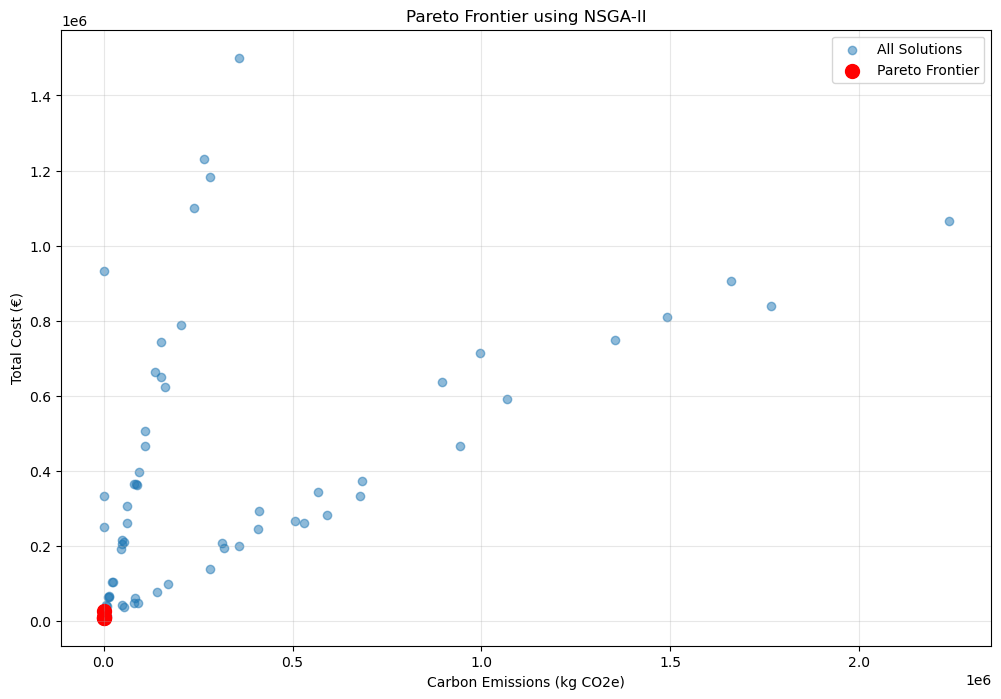

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def fast_non_dominated_sort(costs: np.ndarray) -> List[List[int]]:
    """
    Fast Non-Dominated Sorting (NSGA-II)
    :param costs: An (n_points, n_costs) array
    :return: A list of Pareto fronts, each containing indices of points
    """
    n = costs.shape[0]
    S = [[] for _ in range(n)]
    frontiers = [[]]
    n_dom = np.zeros(n, dtype=int)
    
    for p in range(n):
        for q in range(n):
            if np.all(costs[p] <= costs[q]) and np.any(costs[p] < costs[q]):
                S[p].append(q)
            elif np.all(costs[q] <= costs[p]) and np.any(costs[q] < costs[p]):
                n_dom[p] += 1
        
        if n_dom[p] == 0:
            frontiers[0].append(p)
    
    i = 0
    while frontiers[i]:
        next_front = []
        for p in frontiers[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        frontiers.append(next_front)
        i += 1
    
    return frontiers[:-1]

class NSGA2ParetoOptimizer:
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        self.data['total_cost'] = (
            data['fuel_costs'] + 
            data['insurance_cost'] + 
            data['maintenance_cost']
        )
    
    def find_pareto_frontier(self) -> pd.DataFrame:
        """
        Find the Pareto frontier using Fast Non-Dominated Sorting (NSGA-II)
        """
        costs = np.column_stack([
            self.data['carbon_emissions'],
            self.data['total_cost']
        ])
        
        pareto_fronts = fast_non_dominated_sort(costs)
        pareto_indices = pareto_fronts[0]  # First front is the Pareto frontier
        
        return self.data.iloc[pareto_indices].sort_values('carbon_emissions')
    
    def plot_pareto_frontier(self):
        """
        Plot all solutions and highlight the Pareto frontier
        """
        plt.figure(figsize=(12, 8))
        
        plt.scatter(
            self.data['carbon_emissions'],
            self.data['total_cost'],
            alpha=0.5,
            label='All Solutions'
        )
        
        pareto_points = self.find_pareto_frontier()
        plt.scatter(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            color='red',
            s=100,
            label='Pareto Frontier'
        )
        
        plt.plot(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            'r--',
            alpha=0.5
        )
        
        plt.xlabel('Carbon Emissions (kg CO2e)')
        plt.ylabel('Total Cost (€)')
        plt.title('Pareto Frontier using NSGA-II')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Example usage
data = pd.read_csv('data/something.csv')
optimizer = NSGA2ParetoOptimizer(data)
optimizer.plot_pareto_frontier()



Pareto Frontier Solutions:
                ID  Num_Vehicles         Fuel  carbon_emissions    total_cost
34     BEV_S4_2023           1.0  Electricity          0.000000  26256.007297
50     LNG_S4_2023           1.0       BioLNG        113.703206  11934.078991
48  Diesel_S4_2023           1.0          HVO        193.911994   9797.811293
47  Diesel_S4_2023           1.0          B20       1212.319794   9561.807833


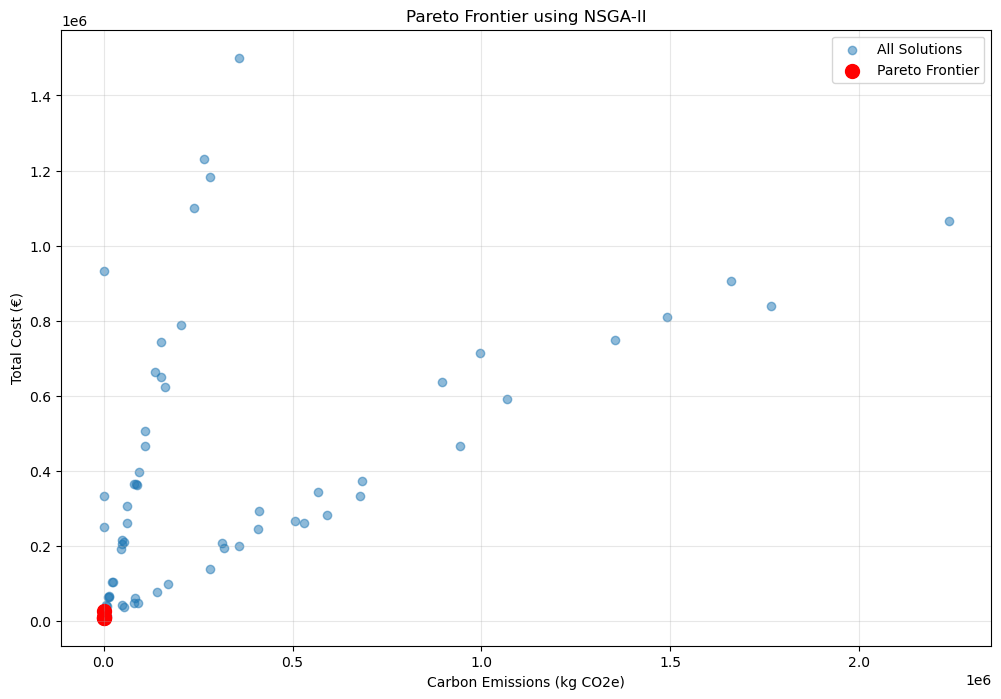


Optimization Summary (sorted by carbon emissions):
                ID  Num_Vehicles         Fuel  carbon_emissions  \
34     BEV_S4_2023           1.0  Electricity          0.000000   
50     LNG_S4_2023           1.0       BioLNG        113.703206   
48  Diesel_S4_2023           1.0          HVO        193.911994   
47  Diesel_S4_2023           1.0          B20       1212.319794   

    carbon_per_vehicle    total_cost  cost_per_vehicle  \
34            0.000000  26256.007297      26256.007297   
50          113.703206  11934.078991      11934.078991   
48          193.911994   9797.811293       9797.811293   
47         1212.319794   9561.807833       9561.807833   

    carbon_reduction_vs_max  cost_reduction_vs_max  
34               100.000000               0.000000  
50                90.621022              54.547244  
48                84.004881              62.683544  
47                 0.000000              63.582400  


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def fast_non_dominated_sort(costs: np.ndarray) -> List[List[int]]:
    """
    Fast Non-Dominated Sorting (NSGA-II)
    :param costs: An (n_points, n_costs) array
    :return: A list of Pareto fronts, each containing indices of points
    """
    n = costs.shape[0]
    S = [[] for _ in range(n)]
    frontiers = [[]]
    n_dom = np.zeros(n, dtype=int)
    
    for p in range(n):
        for q in range(n):
            if np.all(costs[p] <= costs[q]) and np.any(costs[p] < costs[q]):
                S[p].append(q)
            elif np.all(costs[q] <= costs[p]) and np.any(costs[q] < costs[p]):
                n_dom[p] += 1
        
        if n_dom[p] == 0:
            frontiers[0].append(p)
    
    i = 0
    while frontiers[i]:
        next_front = []
        for p in frontiers[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        frontiers.append(next_front)
        i += 1
    
    return frontiers[:-1]

class NSGA2ParetoOptimizer:
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        self.data['total_cost'] = (
            data['fuel_costs'] + 
            data['insurance_cost'] + 
            data['maintenance_cost']
        )
    
    def find_pareto_frontier(self) -> pd.DataFrame:
        """
        Find the Pareto frontier using Fast Non-Dominated Sorting (NSGA-II)
        """
        costs = np.column_stack([
            self.data['carbon_emissions'],
            self.data['total_cost']
        ])
        
        pareto_fronts = fast_non_dominated_sort(costs)
        pareto_indices = pareto_fronts[0]  # First front is the Pareto frontier
        
        return self.data.iloc[pareto_indices].sort_values('carbon_emissions')
    
    def plot_pareto_frontier(self):
        """
        Plot all solutions and highlight the Pareto frontier
        """
        plt.figure(figsize=(12, 8))
        
        plt.scatter(
            self.data['carbon_emissions'],
            self.data['total_cost'],
            alpha=0.5,
            label='All Solutions'
        )
        
        pareto_points = self.find_pareto_frontier()
        plt.scatter(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            color='red',
            s=100,
            label='Pareto Frontier'
        )
        
        plt.plot(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            'r--',
            alpha=0.5
        )
        
        plt.xlabel('Carbon Emissions (kg CO2e)')
        plt.ylabel('Total Cost (€)')
        plt.title('Pareto Frontier using NSGA-II')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def get_optimization_summary(self) -> pd.DataFrame:
        """
        Generate a summary of the Pareto-optimal solutions
        """
        pareto_points = self.find_pareto_frontier()
        summary = pareto_points[[
            'ID', 'Num_Vehicles', 'Fuel',
            'carbon_emissions', 'total_cost'
        ]].copy()
        
        summary['carbon_per_vehicle'] = summary['carbon_emissions'] / summary['Num_Vehicles']
        summary['cost_per_vehicle'] = summary['total_cost'] / summary['Num_Vehicles']
        
        summary['carbon_reduction_vs_max'] = (
            (summary['carbon_emissions'].max() - summary['carbon_emissions']) /
            summary['carbon_emissions'].max() * 100
        )
        summary['cost_reduction_vs_max'] = (
            (summary['total_cost'].max() - summary['total_cost']) /
            summary['total_cost'].max() * 100
        )
        
        return summary.sort_values('carbon_emissions')

# Example usage
data = pd.read_csv('data/something.csv')
optimizer = NSGA2ParetoOptimizer(data)
pareto_frontier = optimizer.find_pareto_frontier()
print("\nPareto Frontier Solutions:")
print(pareto_frontier[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

optimizer.plot_pareto_frontier()

summary = optimizer.get_optimization_summary()
print("\nOptimization Summary (sorted by carbon emissions):")
print(summary[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'carbon_per_vehicle', 'total_cost', 'cost_per_vehicle', 'carbon_reduction_vs_max', 'cost_reduction_vs_max']])



Pareto Frontier Solutions (PSO):
                ID  Num_Vehicles         Fuel  carbon_emissions    total_cost
0      BEV_S1_2023           9.0  Electricity      0.000000e+00  2.498512e+05
51     BEV_S3_2023          30.0  Electricity      0.000000e+00  9.324195e+05
38     LNG_S4_2023           1.0       BioLNG      9.161625e+02  1.424074e+04
47  Diesel_S4_2023           1.0          B20      1.212320e+03  9.561808e+03
19  Diesel_S2_2023          10.0          HVO      1.086856e+05  4.667881e+05
64  Diesel_S3_2023           3.0          B20      1.403331e+05  7.747062e+04
15     LNG_S1_2023           5.0          LNG      1.704831e+05  9.936884e+04
53  Diesel_S3_2023          30.0          HVO      2.385834e+05  1.100427e+06
39  Diesel_S4_2023           7.0          B20      5.057813e+05  2.660804e+05
26  Diesel_S2_2023           8.0          B20      5.309366e+05  2.625398e+05
54     LNG_S3_2023          30.0          LNG      8.947472e+05  6.361136e+05
22  Diesel_S2_2023          14

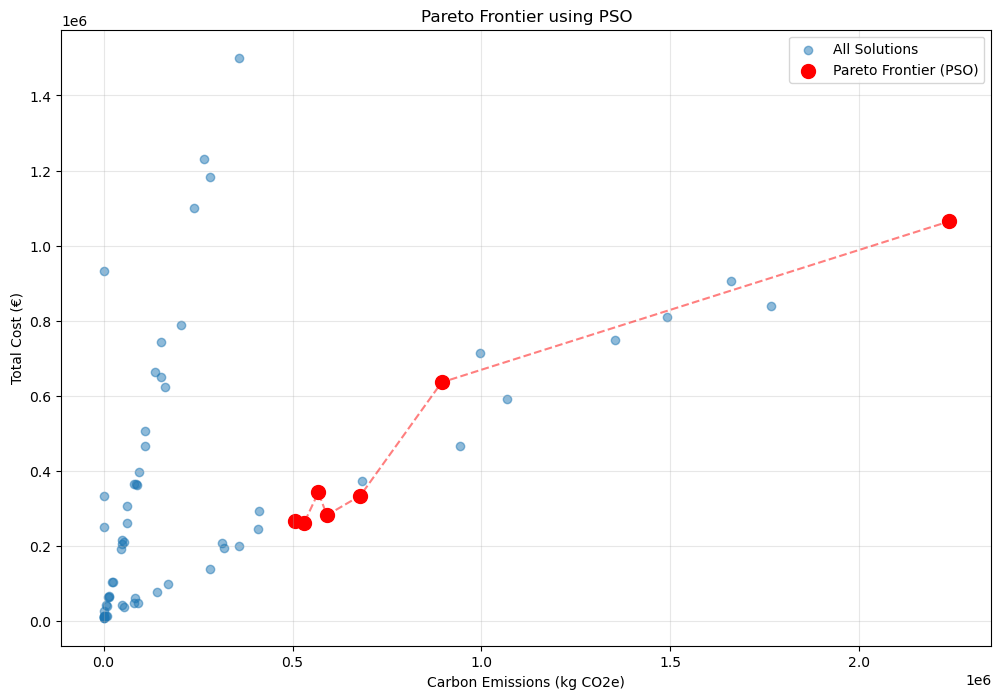


Optimization Summary (PSO, sorted by carbon emissions):
                ID  Num_Vehicles         Fuel  carbon_emissions  \
17     BEV_S2_2023          10.0  Electricity      0.000000e+00   
51     BEV_S3_2023          30.0  Electricity      0.000000e+00   
38     LNG_S4_2023           1.0       BioLNG      9.161625e+02   
47  Diesel_S4_2023           1.0          B20      1.212320e+03   
3      LNG_S1_2023           9.0          LNG      3.576522e+05   
10  Diesel_S1_2023          33.0          HVO      3.579995e+05   
20     LNG_S2_2023          10.0          LNG      4.090466e+05   
62     LNG_S3_2023          14.0          LNG      4.107918e+05   
24     LNG_S2_2023          14.0          LNG      5.682384e+05   
1   Diesel_S1_2023           9.0          B20      5.909406e+05   
60  Diesel_S3_2023          14.0          B20      6.848165e+05   
9   Diesel_S1_2023          33.0          B20      2.238179e+06   

    carbon_per_vehicle    total_cost  cost_per_vehicle  \
17           

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class PSOParetoOptimizer:
    def __init__(self, data: pd.DataFrame, num_particles=30, max_iter=100):
        self.data = data.copy()
        self.data['total_cost'] = (
            data['fuel_costs'] + 
            data['insurance_cost'] + 
            data['maintenance_cost']
        )
        self.num_particles = num_particles
        self.max_iter = max_iter
    
    def is_pareto_efficient(self, costs: np.ndarray) -> np.ndarray:
        """
        Fast Pareto dominance check
        """
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
        return is_efficient
    
    def pso_optimize(self):
        """
        Particle Swarm Optimization (PSO) for Pareto Frontier
        """
        num_solutions = len(self.data)
        costs = np.column_stack([
            self.data['carbon_emissions'],
            self.data['total_cost']
        ])
        
        positions = costs.copy()
        velocities = np.random.uniform(-1, 1, positions.shape)
        personal_best = positions.copy()
        global_best = positions[np.argmin(positions[:, 1])]
        
        inertia_weight = 0.5
        cognitive_weight = 1.5
        social_weight = 1.5
        
        for _ in range(self.max_iter):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities = (
                inertia_weight * velocities +
                cognitive_weight * r1 * (personal_best - positions) +
                social_weight * r2 * (global_best - positions)
            )
            positions += velocities
            
            for i in range(num_solutions):
                if np.all(positions[i] <= personal_best[i]):
                    personal_best[i] = positions[i]
            
            global_best = personal_best[np.argmin(personal_best[:, 1])]
        
        pareto_mask = self.is_pareto_efficient(personal_best)
        return self.data[pareto_mask].sort_values('carbon_emissions')
    
    def plot_pareto_frontier(self):
        """
        Plot all solutions and highlight the Pareto frontier using PSO
        """
        plt.figure(figsize=(12, 8))
        plt.scatter(
            self.data['carbon_emissions'],
            self.data['total_cost'],
            alpha=0.5,
            label='All Solutions'
        )
        
        pareto_points = self.pso_optimize()
        plt.scatter(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            color='red',
            s=100,
            label='Pareto Frontier (PSO)'
        )
        
        plt.plot(
            pareto_points['carbon_emissions'],
            pareto_points['total_cost'],
            'r--',
            alpha=0.5
        )
        
        plt.xlabel('Carbon Emissions (kg CO2e)')
        plt.ylabel('Total Cost (€)')
        plt.title('Pareto Frontier using PSO')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def get_optimization_summary(self) -> pd.DataFrame:
        """
        Generate a summary of the Pareto-optimal solutions using PSO
        """
        pareto_points = self.pso_optimize()
        summary = pareto_points[[
            'ID', 'Num_Vehicles', 'Fuel',
            'carbon_emissions', 'total_cost'
        ]].copy()
        
        summary['carbon_per_vehicle'] = summary['carbon_emissions'] / summary['Num_Vehicles']
        summary['cost_per_vehicle'] = summary['total_cost'] / summary['Num_Vehicles']
        
        summary['carbon_reduction_vs_max'] = (
            (summary['carbon_emissions'].max() - summary['carbon_emissions']) /
            summary['carbon_emissions'].max() * 100
        )
        summary['cost_reduction_vs_max'] = (
            (summary['total_cost'].max() - summary['total_cost']) /
            summary['total_cost'].max() * 100
        )
        
        return summary.sort_values('carbon_emissions')

# Example usage
data = pd.read_csv('data/something.csv')
optimizer = PSOParetoOptimizer(data)
pareto_frontier_pso = optimizer.pso_optimize()
print("\nPareto Frontier Solutions (PSO):")
print(pareto_frontier_pso[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

optimizer.plot_pareto_frontier()

summary_pso = optimizer.get_optimization_summary()
print("\nOptimization Summary (PSO, sorted by carbon emissions):")
print(summary_pso[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'carbon_per_vehicle', 'total_cost', 'cost_per_vehicle', 'carbon_reduction_vs_max', 'cost_reduction_vs_max']])


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from typing import List
import random

class ParetoOptimization:
    def __init__(self, data: pd.DataFrame, num_particles=30, max_iter=100):
        self.data = data.copy()
        self.data['total_cost'] = (
            data['fuel_costs'] + 
            data['insurance_cost'] + 
            data['maintenance_cost']
        )
        self.num_particles = num_particles
        self.max_iter = max_iter

    def is_pareto_efficient(self, costs: np.ndarray) -> np.ndarray:
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
        return is_efficient

    def pso_optimize(self):
        num_solutions = len(self.data)
        costs = np.column_stack([
            self.data['carbon_emissions'],
            self.data['total_cost']
        ])
        
        positions = costs.copy()
        velocities = np.random.uniform(-1, 1, positions.shape)
        personal_best = positions.copy()
        global_best = positions[np.argmin(positions[:, 1])]
        
        inertia_weight = 0.5
        cognitive_weight = 1.5
        social_weight = 1.5
        
        for _ in range(self.max_iter):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities = (
                inertia_weight * velocities +
                cognitive_weight * r1 * (personal_best - positions) +
                social_weight * r2 * (global_best - positions)
            )
            positions += velocities
            
            for i in range(num_solutions):
                if np.all(positions[i] <= personal_best[i]):
                    personal_best[i] = positions[i]
            
            global_best = personal_best[np.argmin(personal_best[:, 1])]
        
        pareto_mask = self.is_pareto_efficient(personal_best)
        return self.data[pareto_mask].sort_values('carbon_emissions')

    def nsga2_optimize(self, population_size=50, generations=100):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_float", random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        
        def evaluate(individual):
            index = int(individual[0] * (len(self.data) - 1))
            return (self.data.iloc[index]['carbon_emissions'], self.data.iloc[index]['total_cost'])
        
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=1.0, indpb=0.2)
        toolbox.register("select", tools.selNSGA2)
        toolbox.register("evaluate", evaluate)
        
        population = toolbox.population(n=population_size)
        algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, cxpb=0.7, mutpb=0.2, ngen=generations, stats=None, halloffame=None, verbose=False)
        
        pareto_front = [ind for ind in population if ind.fitness.valid]
        indices = [int(ind[0] * (len(self.data) - 1)) for ind in pareto_front]
        return self.data.iloc[indices].sort_values('carbon_emissions')

    def plot_comparison(self):
        plt.figure(figsize=(12, 8))
        plt.scatter(self.data['carbon_emissions'], self.data['total_cost'], alpha=0.5, label='All Solutions')
        
        pareto_pso = self.pso_optimize()
        pareto_nsga2 = self.nsga2_optimize()
        
        plt.scatter(pareto_pso['carbon_emissions'], pareto_pso['total_cost'], color='red', s=100, label='Pareto Frontier (PSO)')
        plt.scatter(pareto_nsga2['carbon_emissions'], pareto_nsga2['total_cost'], color='blue', s=100, label='Pareto Frontier (NSGA-II)')
        
        plt.plot(pareto_pso['carbon_emissions'], pareto_pso['total_cost'], 'r--', alpha=0.5)
        plt.plot(pareto_nsga2['carbon_emissions'], pareto_nsga2['total_cost'], 'b--', alpha=0.5)
        
        plt.xlabel('Carbon Emissions (kg CO2e)')
        plt.ylabel('Total Cost (€)')
        plt.title('Comparison: Pareto Frontiers (PSO vs. NSGA-II)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Load dataset
data = pd.read_csv('data/something.csv')
optimizer = ParetoOptimization(data)

# Get Pareto frontiers
pareto_frontier_pso = optimizer.pso_optimize()
pareto_frontier_nsga2 = optimizer.nsga2_optimize()

# Print results
print("\nPareto Frontier Solutions (PSO):")
print(pareto_frontier_pso[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

print("\nPareto Frontier Solutions (NSGA-II):")
print(pareto_frontier_nsga2[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

# Plot results
optimizer.plot_comparison()


c:\Users\hjain\anaconda3\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


IndexError: single positional indexer is out-of-bounds


Pareto Frontier Solutions (PSO):
                ID  Num_Vehicles         Fuel  carbon_emissions    total_cost
34     BEV_S4_2023           1.0  Electricity      0.000000e+00  2.625601e+04
51     BEV_S3_2023          30.0  Electricity      0.000000e+00  9.324195e+05
38     LNG_S4_2023           1.0       BioLNG      9.161625e+02  1.424074e+04
47  Diesel_S4_2023           1.0          B20      1.212320e+03  9.561808e+03
54     LNG_S3_2023          30.0          LNG      8.947472e+05  6.361136e+05
58     LNG_S3_2023          34.0          LNG      9.965475e+05  7.138083e+05
7      LNG_S1_2023          26.0          LNG      1.068657e+06  5.908319e+05
9   Diesel_S1_2023          33.0          B20      2.238179e+06  1.064605e+06

Pareto Frontier Solutions (NSGA-II):
                ID  Num_Vehicles         Fuel  carbon_emissions    total_cost
34     BEV_S4_2023           1.0  Electricity          0.000000  26256.007297
50     LNG_S4_2023           1.0       BioLNG        113.703206  11934

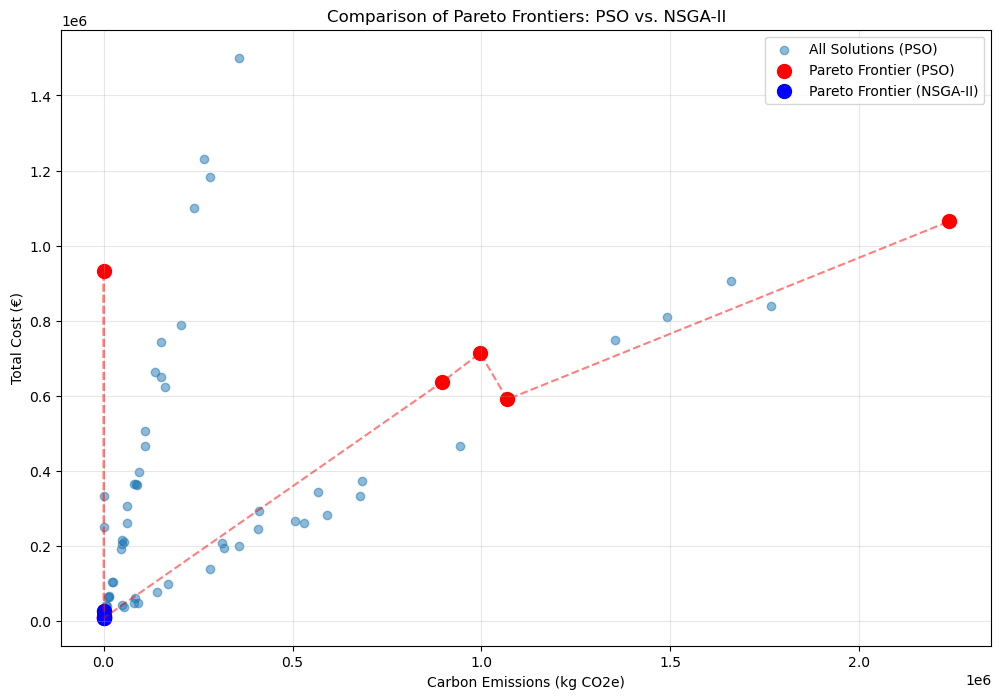


Optimization Summary (PSO, sorted by carbon emissions):
                ID  Num_Vehicles         Fuel  carbon_emissions  \
0      BEV_S1_2023           9.0  Electricity      0.000000e+00   
51     BEV_S3_2023          30.0  Electricity      0.000000e+00   
34     BEV_S4_2023           1.0  Electricity      0.000000e+00   
17     BEV_S2_2023          10.0  Electricity      0.000000e+00   
38     LNG_S4_2023           1.0       BioLNG      9.161625e+02   
47  Diesel_S4_2023           1.0          B20      1.212320e+03   
19  Diesel_S2_2023          10.0          HVO      1.086856e+05   
64  Diesel_S3_2023           3.0          B20      1.403331e+05   
23  Diesel_S2_2023          14.0          HVO      1.509836e+05   
8      LNG_S1_2023          26.0       BioLNG      1.623251e+05   
15     LNG_S1_2023           5.0          LNG      1.704831e+05   
10  Diesel_S1_2023          33.0          HVO      3.579995e+05   
62     LNG_S3_2023          14.0          LNG      4.107918e+05   
39  D

In [36]:
# Compare PSO vs NSGA-II results

# PSO Optimization
pso_optimizer = PSOParetoOptimizer(data)
pareto_frontier_pso = pso_optimizer.pso_optimize()

# NSGA-II Optimization
nsga2_optimizer = NSGA2ParetoOptimizer(data)
pareto_frontier_nsga2 = nsga2_optimizer.find_pareto_frontier()

# Print Pareto Frontiers
print("\nPareto Frontier Solutions (PSO):")
print(pareto_frontier_pso[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

print("\nPareto Frontier Solutions (NSGA-II):")
print(pareto_frontier_nsga2[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'total_cost']])

# Plot Both Pareto Frontiers
plt.figure(figsize=(12, 8))

# Plot PSO Pareto Frontier
plt.scatter(
    pso_optimizer.data['carbon_emissions'],
    pso_optimizer.data['total_cost'],
    alpha=0.5,
    label='All Solutions (PSO)'
)
plt.scatter(
    pareto_frontier_pso['carbon_emissions'],
    pareto_frontier_pso['total_cost'],
    color='red',
    s=100,
    label='Pareto Frontier (PSO)'
)
plt.plot(
    pareto_frontier_pso['carbon_emissions'],
    pareto_frontier_pso['total_cost'],
    'r--',
    alpha=0.5
)

# Plot NSGA-II Pareto Frontier
# plt.scatter(
#     nsga2_optimizer.data['carbon_emissions'],
#     nsga2_optimizer.data['total_cost'],
#     alpha=0.5,
#     label='All Solutions (NSGA-II)'
# )
plt.scatter(
    pareto_frontier_nsga2['carbon_emissions'],
    pareto_frontier_nsga2['total_cost'],
    color='blue',
    s=100,
    label='Pareto Frontier (NSGA-II)'
)
plt.plot(
    pareto_frontier_nsga2['carbon_emissions'],
    pareto_frontier_nsga2['total_cost'],
    'b--',
    alpha=0.5
)

# Customize Plot
plt.xlabel('Carbon Emissions (kg CO2e)')
plt.ylabel('Total Cost (€)')
plt.title('Comparison of Pareto Frontiers: PSO vs. NSGA-II')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare Summaries (PSO vs NSGA-II)
summary_pso = pso_optimizer.get_optimization_summary()
summary_nsga2 = nsga2_optimizer.get_optimization_summary()

# Print Optimization Summary for PSO
print("\nOptimization Summary (PSO, sorted by carbon emissions):")
print(summary_pso[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'carbon_per_vehicle', 'total_cost', 'cost_per_vehicle', 'carbon_reduction_vs_max', 'cost_reduction_vs_max']])

# Print Optimization Summary for NSGA-II
print("\nOptimization Summary (NSGA-II, sorted by carbon emissions):")
print(summary_nsga2[['ID', 'Num_Vehicles', 'Fuel', 'carbon_emissions', 'carbon_per_vehicle', 'total_cost', 'cost_per_vehicle', 'carbon_reduction_vs_max', 'cost_reduction_vs_max']])
